# 2-3: EDA (탐색적 데이터 분석)
606번, 420번 버스의 혼잡도 패턴을 다각도로 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 데이터 로드
hourly = pd.read_csv('../data/processed/hourly_boarding_clean.csv')
daily = pd.read_csv('../data/processed/daily_boarding_clean.csv')
weather = pd.read_csv('../data/processed/weather_clean.csv')
holidays = pd.read_csv('../data/raw/holidays.csv')

# 타입 변환
daily['사용일자'] = pd.to_datetime(daily['사용일자'])
weather['datetime'] = pd.to_datetime(weather['datetime'])
holidays['날짜'] = pd.to_datetime(holidays['날짜'])

# 일별 데이터에 요일/월 추가
daily['요일'] = daily['사용일자'].dt.dayofweek  # 0=월, 6=일
daily['요일명'] = daily['사용일자'].dt.day_name()
daily['월'] = daily['사용일자'].dt.month
daily['주말'] = daily['요일'].isin([5, 6]).astype(int)
daily['공휴일'] = daily['사용일자'].isin(holidays['날짜']).astype(int)
daily['휴일'] = ((daily['주말'] == 1) | (daily['공휴일'] == 1)).astype(int)

print(f'hourly: {hourly.shape}')
print(f'daily: {daily.shape}')
print(f'weather: {weather.shape}')
print('로드 완료')

hourly: (1366, 54)
daily: (39002, 14)
weather: (4416, 5)
로드 완료


---
## 1. 시간대별 혼잡도 패턴 (출퇴근 vs 한가한 시간)

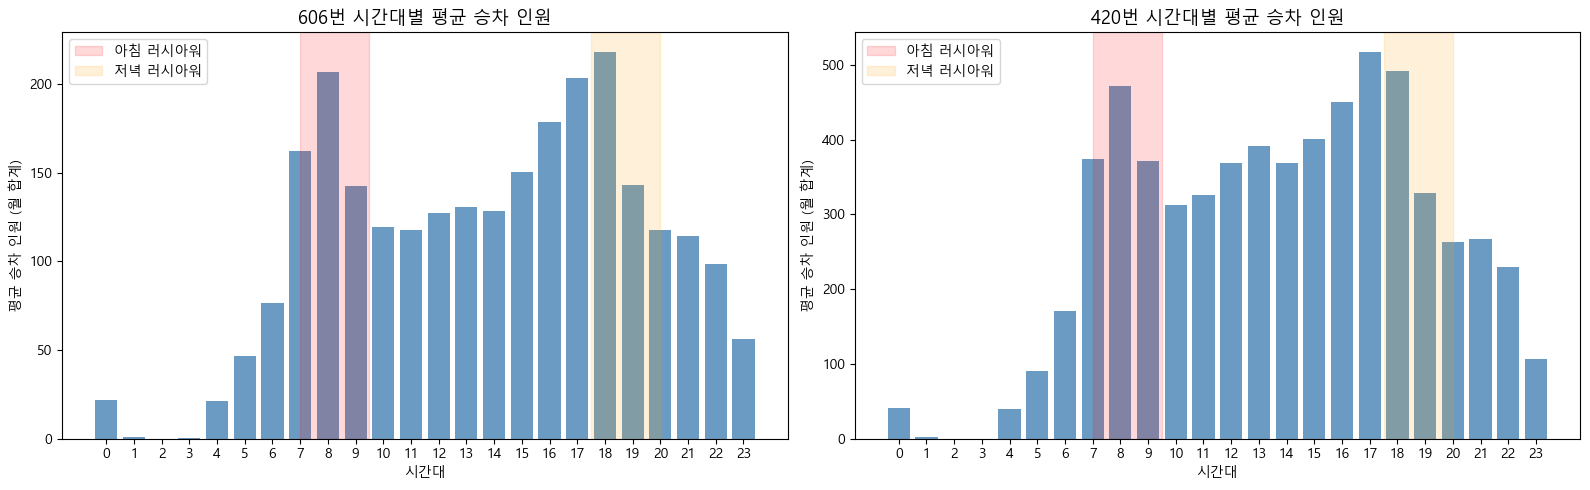

In [2]:
# 노선별 시간대별 평균 승차 인원
# 0시 컬럼은 '00시승차총승객수'로 저장되어 있음
board_cols = ['00시승차총승객수'] + [f'{h}시승차총승객수' for h in range(1, 24)]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, route in enumerate(['606', '420']):
    subset = hourly[hourly['노선번호'].astype(str) == route]
    means = subset[board_cols].mean()
    
    axes[idx].bar(range(24), means.values, color='steelblue', alpha=0.8)
    axes[idx].axvspan(7, 9.5, alpha=0.15, color='red', label='아침 러시아워')
    axes[idx].axvspan(17.5, 20, alpha=0.15, color='orange', label='저녁 러시아워')
    axes[idx].set_title(f'{route}번 시간대별 평균 승차 인원', fontsize=13)
    axes[idx].set_xlabel('시간대')
    axes[idx].set_ylabel('평균 승차 인원 (월 합계)')
    axes[idx].set_xticks(range(24))
    axes[idx].legend()

plt.tight_layout()
plt.show()

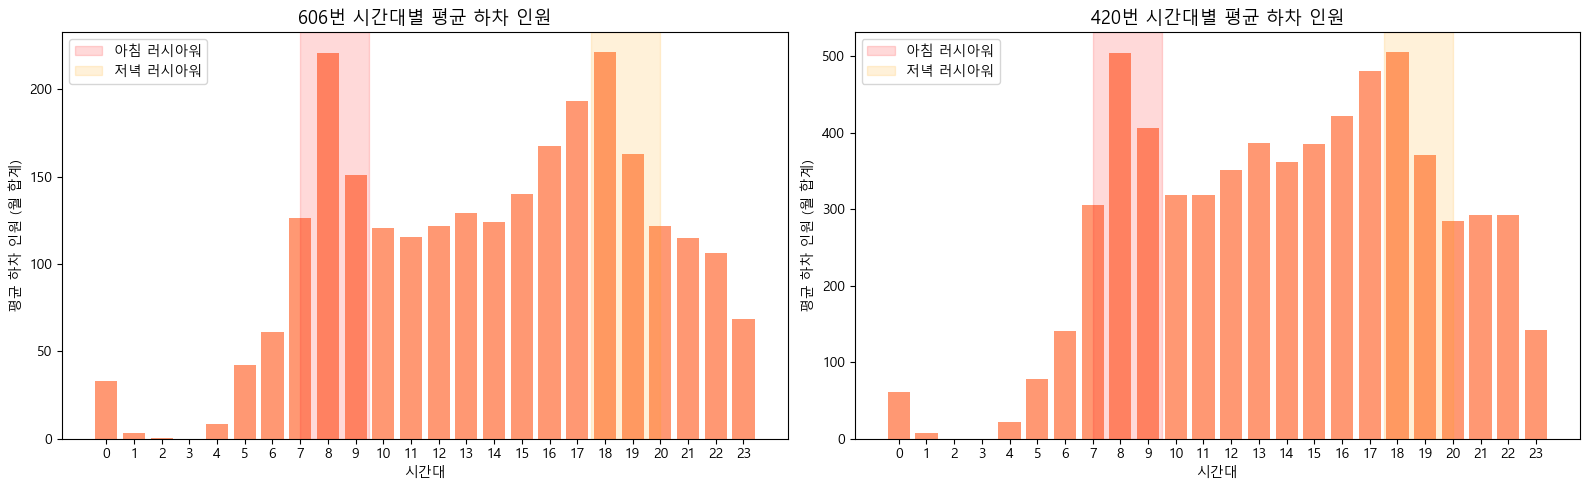

In [3]:
# 노선별 시간대별 평균 하차 인원
alight_cols = ['00시하차총승객수'] + [f'{h}시하차총승객수' for h in range(1, 24)]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, route in enumerate(['606', '420']):
    subset = hourly[hourly['노선번호'].astype(str) == route]
    means = subset[alight_cols].mean()
    
    axes[idx].bar(range(24), means.values, color='coral', alpha=0.8)
    axes[idx].axvspan(7, 9.5, alpha=0.15, color='red', label='아침 러시아워')
    axes[idx].axvspan(17.5, 20, alpha=0.15, color='orange', label='저녁 러시아워')
    axes[idx].set_title(f'{route}번 시간대별 평균 하차 인원', fontsize=13)
    axes[idx].set_xlabel('시간대')
    axes[idx].set_ylabel('평균 하차 인원 (월 합계)')
    axes[idx].set_xticks(range(24))
    axes[idx].legend()

plt.tight_layout()
plt.show()

---
## 2. 요일별 혼잡도 패턴 (평일 vs 주말)

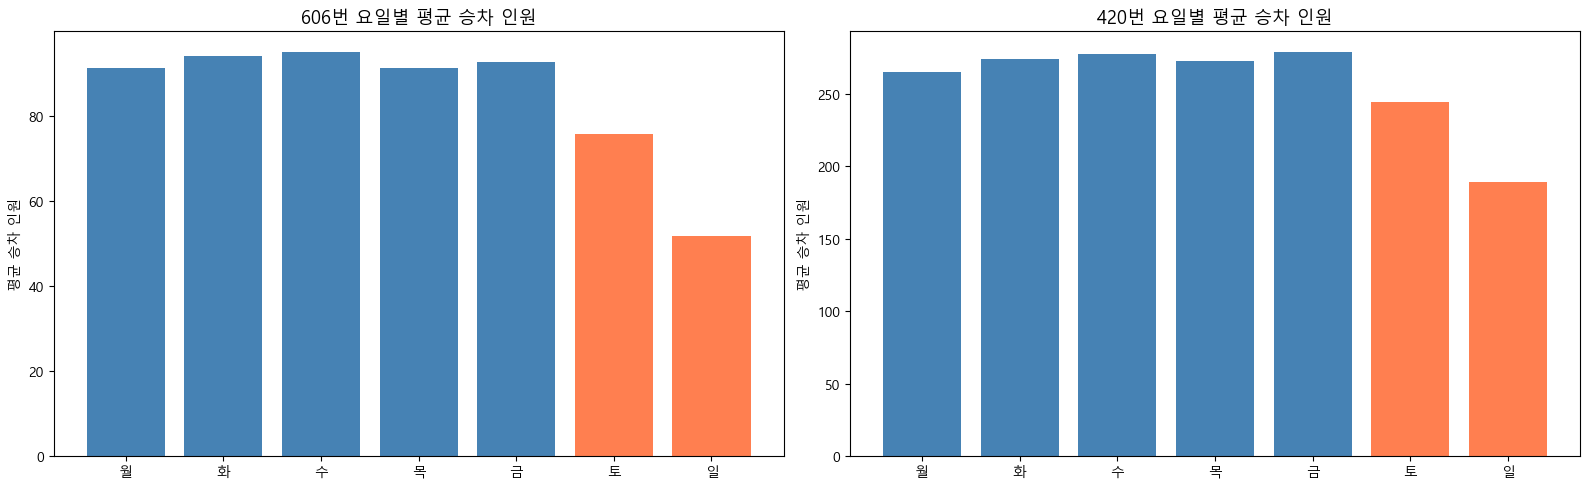

In [4]:
# 노선별 요일별 평균 승차 인원
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_kr = ['월', '화', '수', '목', '금', '토', '일']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, route in enumerate(['606', '420']):
    subset = daily[daily['노선번호'].astype(str) == route]
    day_avg = subset.groupby('요일명')['승차총승객수'].mean().reindex(day_order)
    
    colors = ['steelblue']*5 + ['coral']*2
    axes[idx].bar(day_kr, day_avg.values, color=colors)
    axes[idx].set_title(f'{route}번 요일별 평균 승차 인원', fontsize=13)
    axes[idx].set_ylabel('평균 승차 인원')

plt.tight_layout()
plt.show()

606번 — 평일 평균: 96, 주말/공휴일 평균: 62, 차이: 35.0% 감소
420번 — 평일 평균: 280, 주말/공휴일 평균: 211, 차이: 24.5% 감소


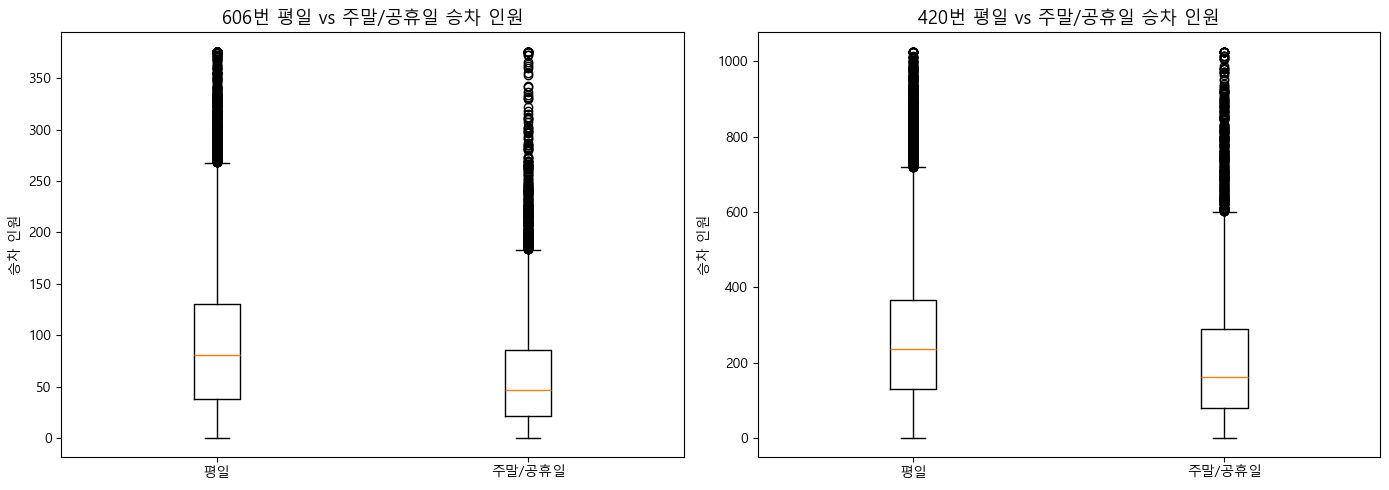

In [5]:
# 평일 vs 주말/공휴일 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, route in enumerate(['606', '420']):
    subset = daily[daily['노선번호'].astype(str) == route]
    weekday = subset[subset['휴일'] == 0]['승차총승객수']
    holiday = subset[subset['휴일'] == 1]['승차총승객수']
    
    axes[idx].boxplot([weekday, holiday], labels=['평일', '주말/공휴일'])
    axes[idx].set_title(f'{route}번 평일 vs 주말/공휴일 승차 인원', fontsize=13)
    axes[idx].set_ylabel('승차 인원')
    
    print(f'{route}번 — 평일 평균: {weekday.mean():.0f}, 주말/공휴일 평균: {holiday.mean():.0f}, 차이: {(1 - holiday.mean()/weekday.mean())*100:.1f}% 감소')

plt.tight_layout()
plt.show()

---
## 3. 월별(계절별) 패턴

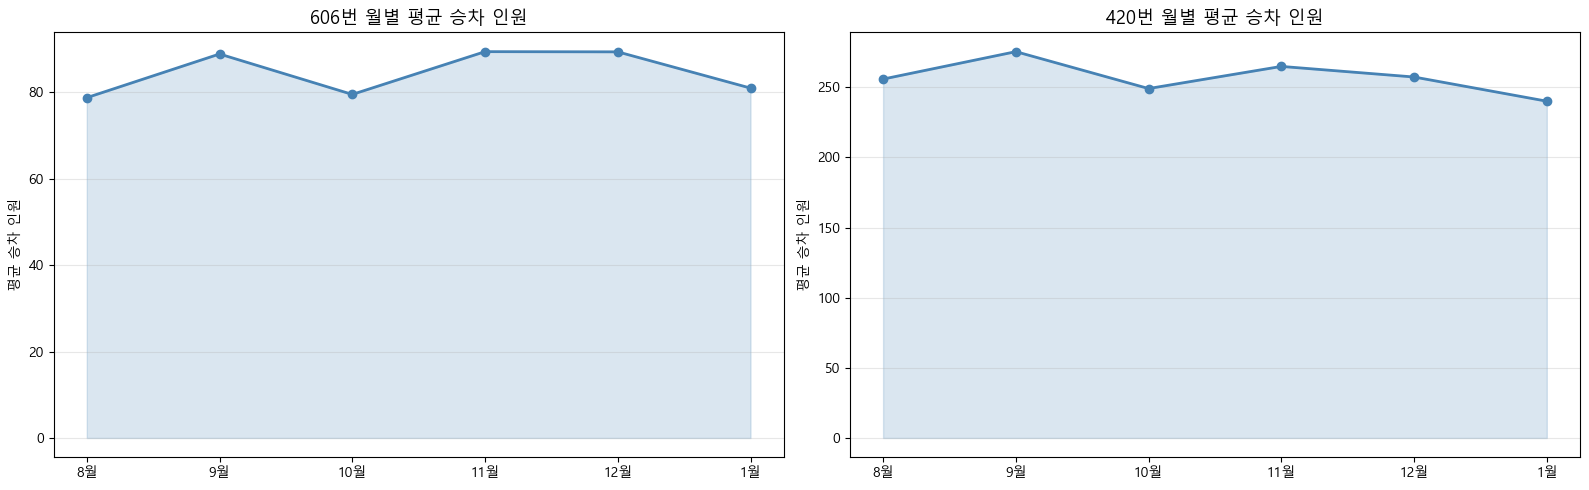

In [6]:
# 월별 평균 승차 인원 추이
month_labels = ['8월', '9월', '10월', '11월', '12월', '1월']
month_order = [8, 9, 10, 11, 12, 1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, route in enumerate(['606', '420']):
    subset = daily[daily['노선번호'].astype(str) == route]
    monthly = subset.groupby('월')['승차총승객수'].mean().reindex(month_order)
    
    axes[idx].plot(month_labels, monthly.values, marker='o', linewidth=2, color='steelblue')
    axes[idx].fill_between(month_labels, monthly.values, alpha=0.2, color='steelblue')
    axes[idx].set_title(f'{route}번 월별 평균 승차 인원', fontsize=13)
    axes[idx].set_ylabel('평균 승차 인원')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. 날씨와 혼잡도의 관계

In [7]:
# 일별 날씨 집계 (일 평균 기온, 일 강수량 합계, 일 평균 풍속)
weather['date'] = weather['datetime'].dt.date
weather_daily = weather.groupby('date').agg(
    temperature=('temperature', 'mean'),
    precipitation=('precipitation', 'sum'),
    wind_speed=('wind_speed', 'mean'),
    snow=('snow', 'max')
).reset_index()
weather_daily['date'] = pd.to_datetime(weather_daily['date'])
weather_daily['비온날'] = (weather_daily['precipitation'] > 0).astype(int)

print(f'일별 날씨 데이터: {weather_daily.shape}')
print(f'비 온 날: {weather_daily["비온날"].sum()}일 / 전체 {len(weather_daily)}일')
weather_daily.head()

일별 날씨 데이터: (184, 6)
비 온 날: 63일 / 전체 184일


,date,temperature,precipitation,wind_speed,snow,비온날
0,2025-08-01,30.983333,0.0,1.787500,0.0,0
1,2025-08-02,31.120833,0.0,1.787500,0.0,0
2,2025-08-03,29.229167,0.1,1.854167,0.0,1
3,2025-08-04,27.808333,3.1,2.229167,0.0,1
4,2025-08-05,28.970833,0.0,2.250000,0.0,0


In [8]:
# 일별 승하차에 날씨 결합
daily_station_sum = daily.groupby(['사용일자', '노선번호']).agg(
    승차합계=('승차총승객수', 'sum'),
    하차합계=('하차총승객수', 'sum')
).reset_index()

daily_weather = daily_station_sum.merge(
    weather_daily, left_on='사용일자', right_on='date', how='left'
).drop(columns='date')

print(f'날씨 결합 데이터: {daily_weather.shape}')
daily_weather.head()

날씨 결합 데이터: (365, 9)


,사용일자,노선번호,승차합계,하차합계,temperature,precipitation,wind_speed,snow,비온날
0,2025-08-01,420,24806,24122,30.983333,0.0,1.787500,0.0,0
1,2025-08-01,606,10613,10540,30.983333,0.0,1.787500,0.0,0
2,2025-08-02,420,21240,20579,31.120833,0.0,1.787500,0.0,0
3,2025-08-02,606,8482,8372,31.120833,0.0,1.787500,0.0,0
4,2025-08-03,420,15370,14916,29.229167,0.1,1.854167,0.0,1


606번 — 맑은 날: 10840, 비 온 날: 9987
420번 — 맑은 날: 23422, 비 온 날: 21749


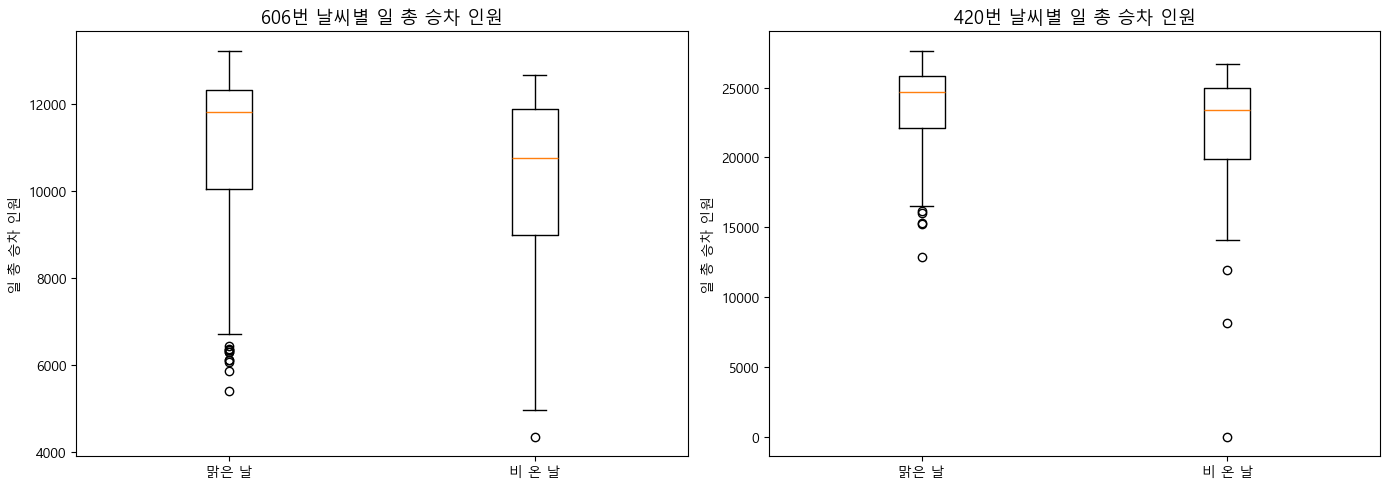

In [9]:
# 비 온 날 vs 안 온 날 승차 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, route in enumerate(['606', '420']):
    subset = daily_weather[daily_weather['노선번호'].astype(str) == route]
    no_rain = subset[subset['비온날'] == 0]['승차합계']
    rain = subset[subset['비온날'] == 1]['승차합계']
    
    axes[idx].boxplot([no_rain, rain], labels=['맑은 날', '비 온 날'])
    axes[idx].set_title(f'{route}번 날씨별 일 총 승차 인원', fontsize=13)
    axes[idx].set_ylabel('일 총 승차 인원')
    
    print(f'{route}번 — 맑은 날: {no_rain.mean():.0f}, 비 온 날: {rain.mean():.0f}')

plt.tight_layout()
plt.show()

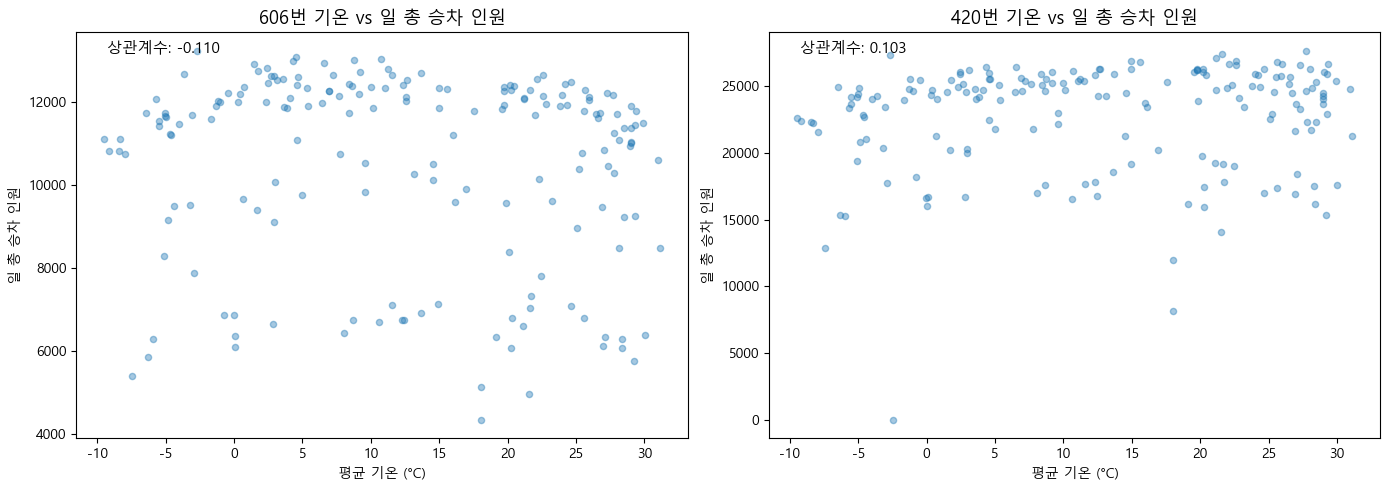

In [10]:
# 기온 vs 승차 인원 산점도
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, route in enumerate(['606', '420']):
    subset = daily_weather[daily_weather['노선번호'].astype(str) == route]
    axes[idx].scatter(subset['temperature'], subset['승차합계'], alpha=0.4, s=20)
    axes[idx].set_title(f'{route}번 기온 vs 일 총 승차 인원', fontsize=13)
    axes[idx].set_xlabel('평균 기온 (°C)')
    axes[idx].set_ylabel('일 총 승차 인원')
    
    corr = subset['temperature'].corr(subset['승차합계'])
    axes[idx].annotate(f'상관계수: {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11)

plt.tight_layout()
plt.show()

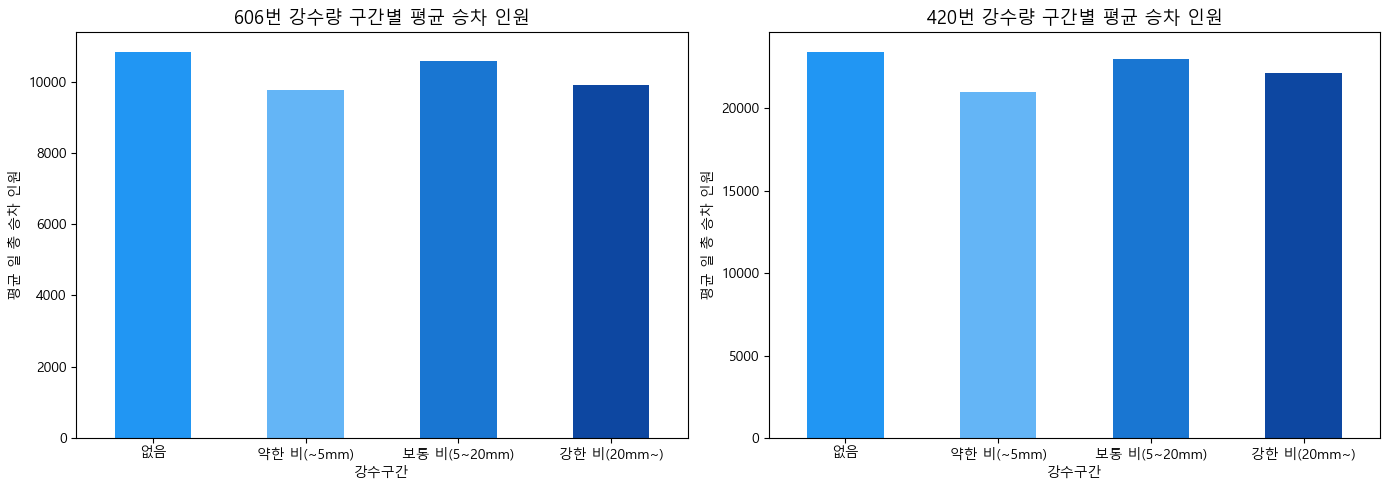

In [11]:
# 강수량 구간별 승차 인원
daily_weather['강수구간'] = pd.cut(
    daily_weather['precipitation'],
    bins=[-0.1, 0, 5, 20, 100],
    labels=['없음', '약한 비(~5mm)', '보통 비(5~20mm)', '강한 비(20mm~)']
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, route in enumerate(['606', '420']):
    subset = daily_weather[daily_weather['노선번호'].astype(str) == route]
    group = subset.groupby('강수구간', observed=True)['승차합계'].mean()
    
    group.plot(kind='bar', ax=axes[idx], color=['#2196F3', '#64B5F6', '#1976D2', '#0D47A1'])
    axes[idx].set_title(f'{route}번 강수량 구간별 평균 승차 인원', fontsize=13)
    axes[idx].set_ylabel('평균 일 총 승차 인원')
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

---
## 5. 정류장별 혼잡도 분포

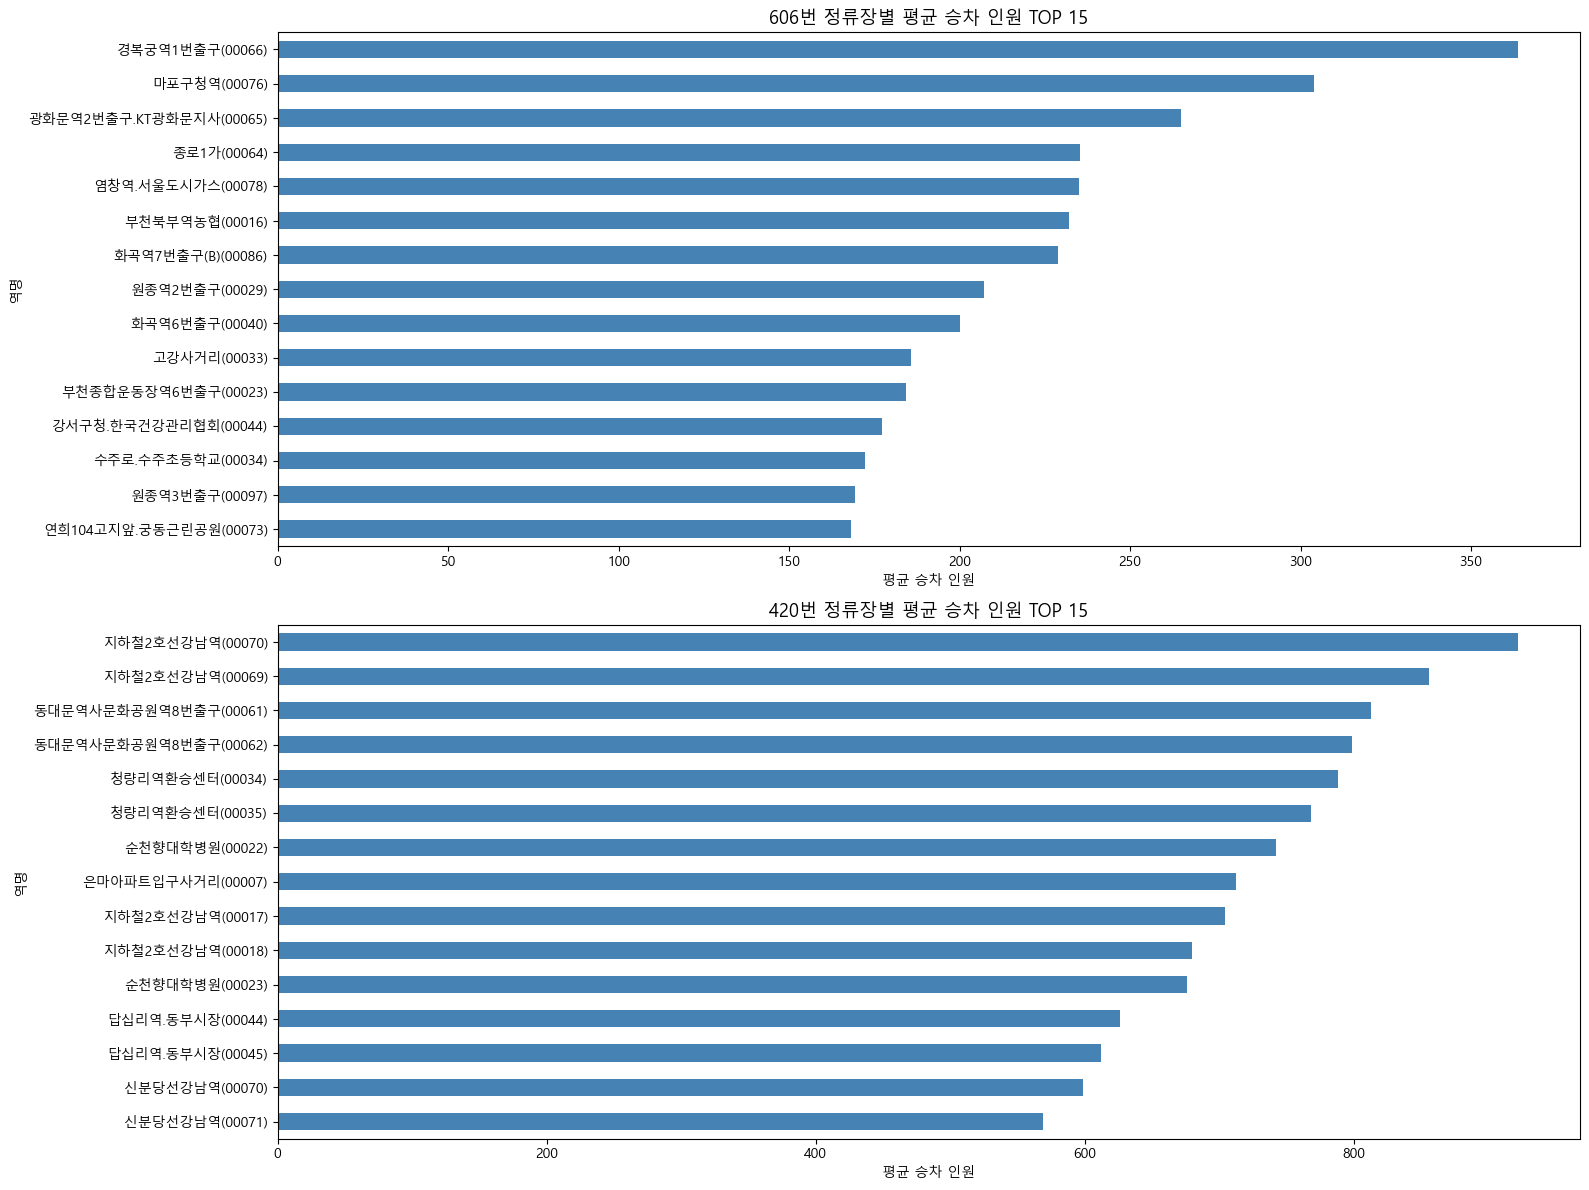

In [12]:
# 정류장별 평균 승차 인원 TOP 15
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

for idx, route in enumerate(['606', '420']):
    subset = daily[daily['노선번호'].astype(str) == route]
    station_avg = subset.groupby('역명')['승차총승객수'].mean().sort_values(ascending=False).head(15)
    
    station_avg.plot(kind='barh', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'{route}번 정류장별 평균 승차 인원 TOP 15', fontsize=13)
    axes[idx].set_xlabel('평균 승차 인원')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

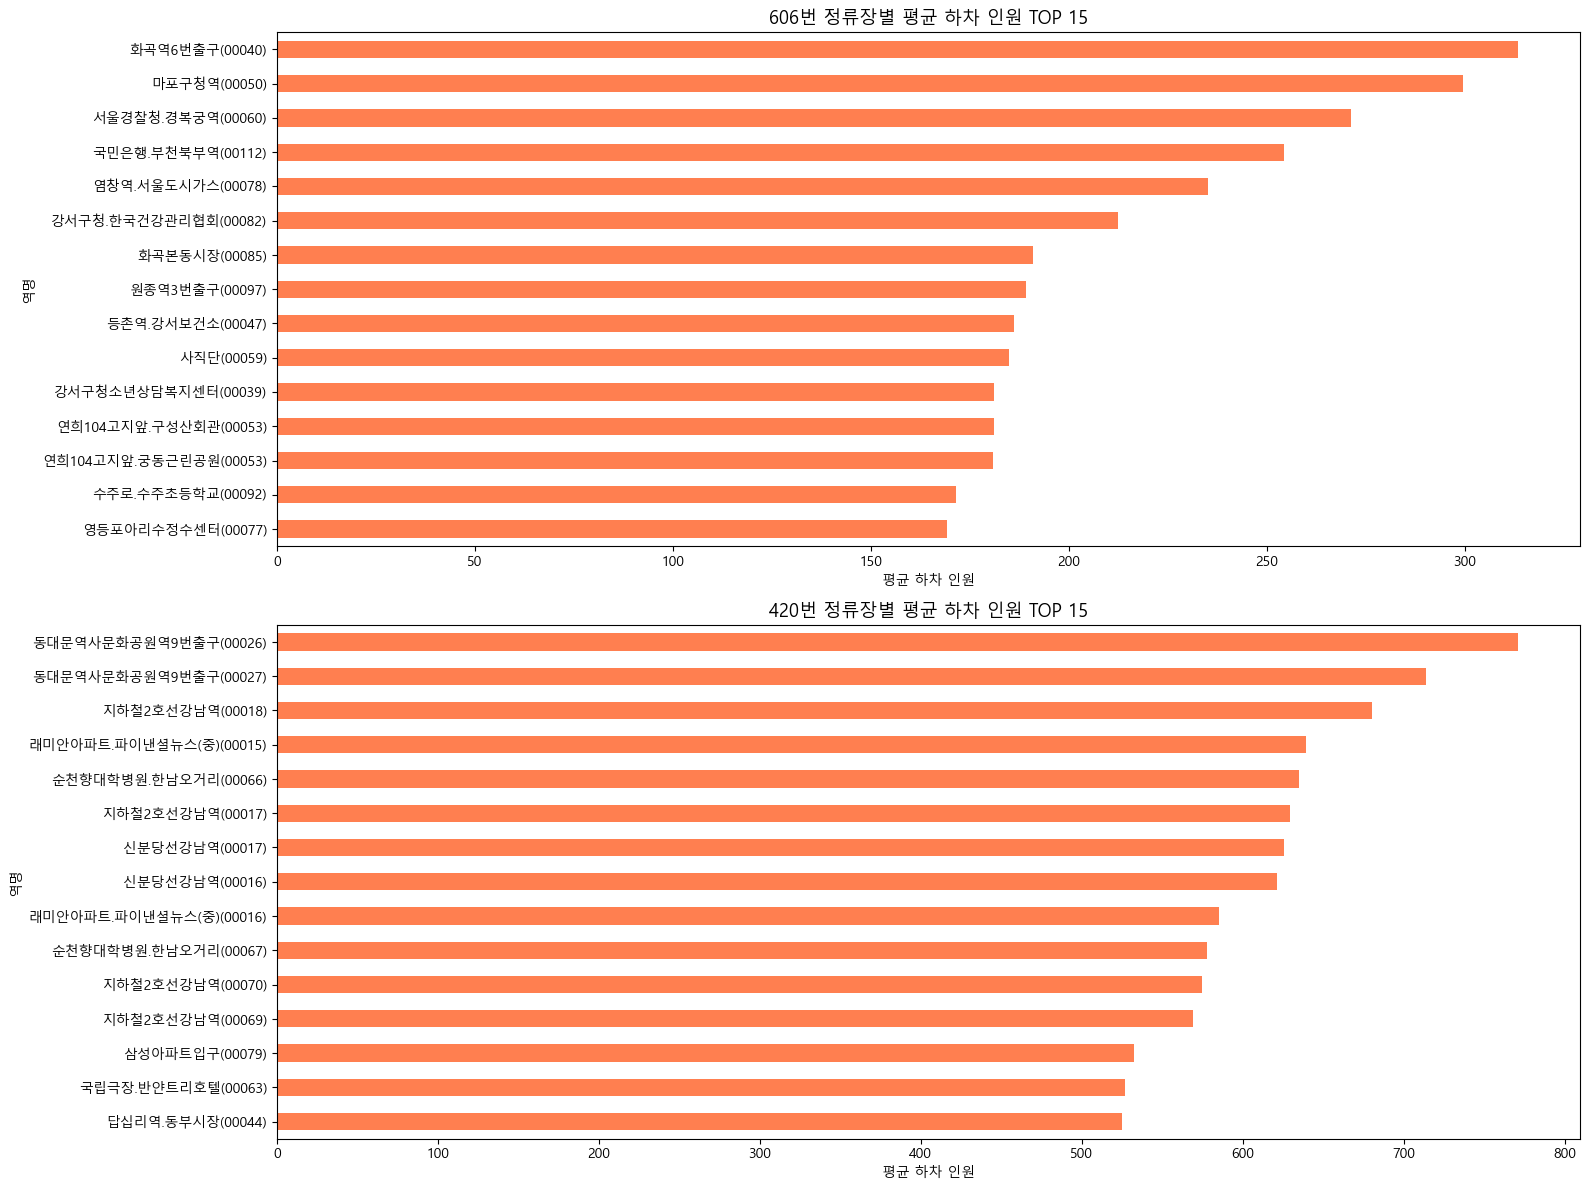

In [13]:
# 정류장별 평균 하차 인원 TOP 15
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

for idx, route in enumerate(['606', '420']):
    subset = daily[daily['노선번호'].astype(str) == route]
    station_avg = subset.groupby('역명')['하차총승객수'].mean().sort_values(ascending=False).head(15)
    
    station_avg.plot(kind='barh', ax=axes[idx], color='coral')
    axes[idx].set_title(f'{route}번 정류장별 평균 하차 인원 TOP 15', fontsize=13)
    axes[idx].set_xlabel('평균 하차 인원')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

---
## 6. 상관관계 히트맵

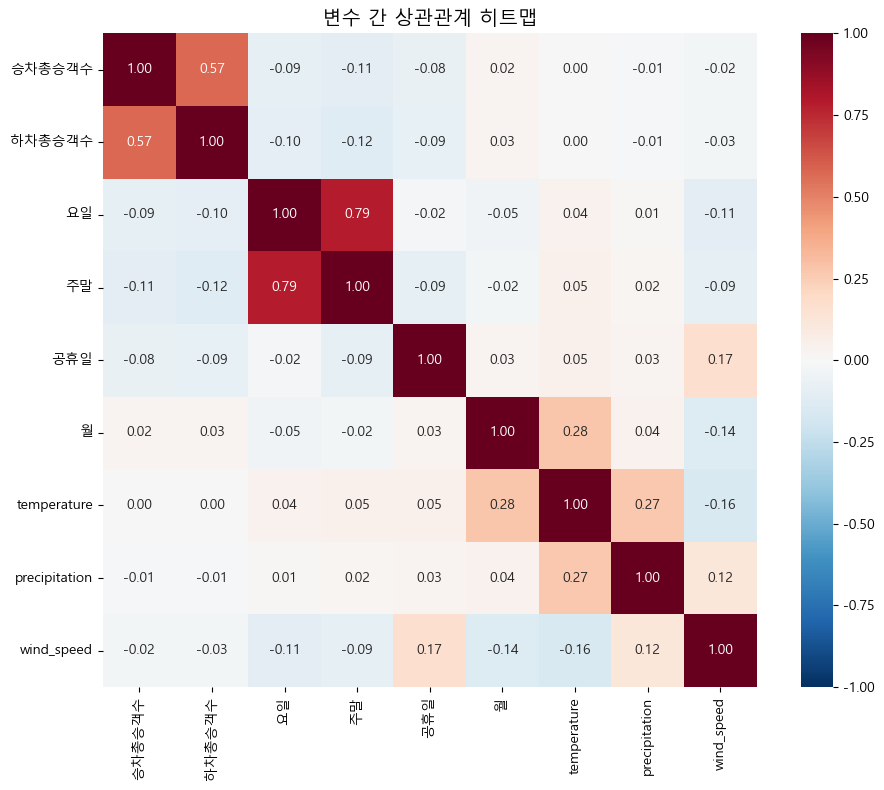

In [14]:
# 일별 데이터에 요일/날씨 피처 추가 후 상관관계
daily_merged = daily.merge(
    weather_daily, left_on='사용일자', right_on='date', how='left'
).drop(columns='date')

corr_cols = ['승차총승객수', '하차총승객수', '요일', '주말', '공휴일', '월',
             'temperature', 'precipitation', 'wind_speed']
corr_matrix = daily_merged[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r',
    center=0, vmin=-1, vmax=1, square=True
)
plt.title('변수 간 상관관계 히트맵', fontsize=14)
plt.tight_layout()
plt.show()

---
## 7. 일별 승차 추이 (시계열)

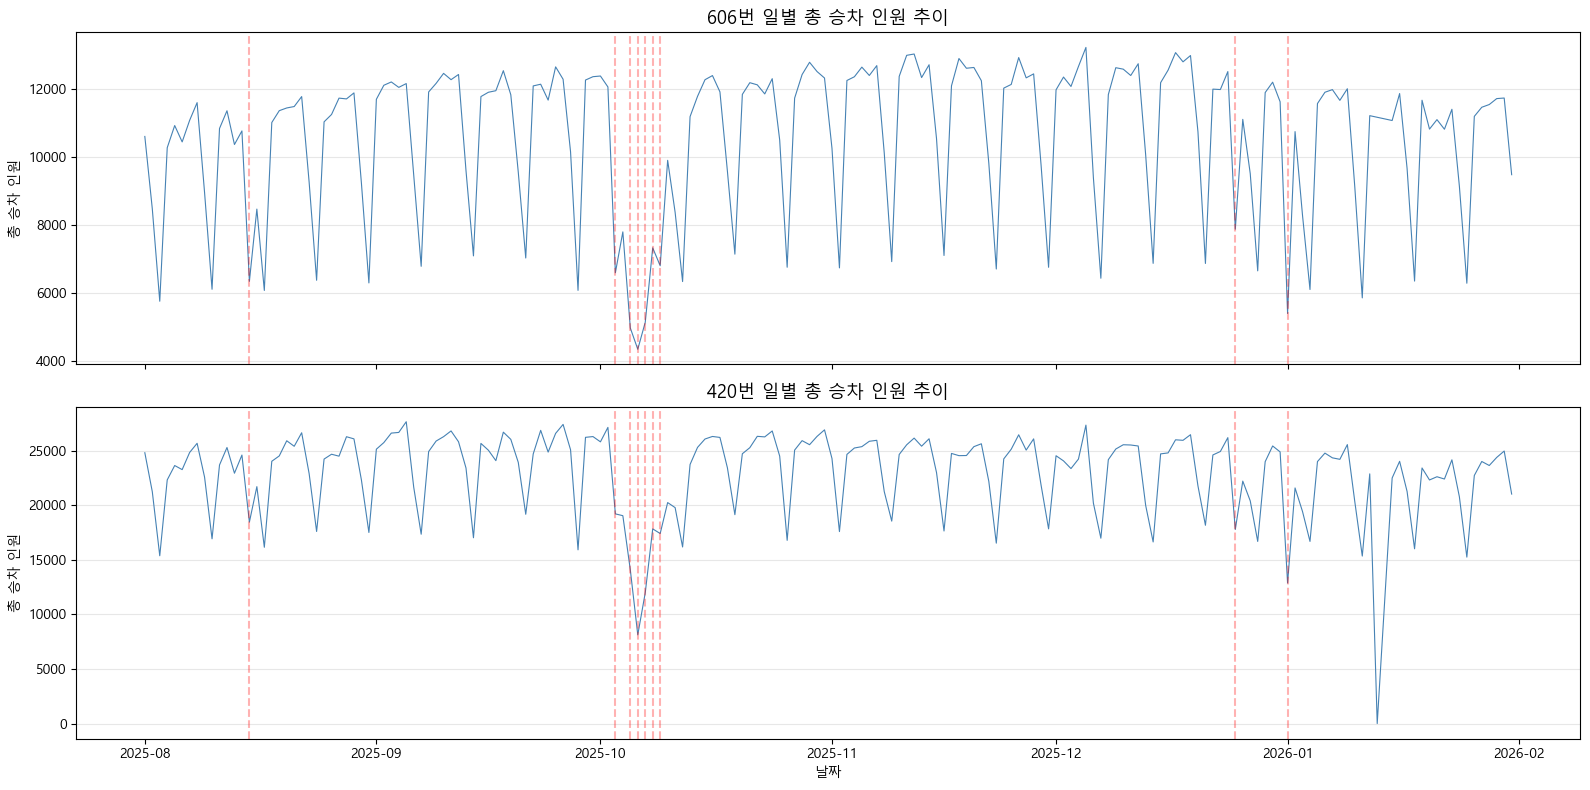

In [15]:
# 노선별 일 총 승차 인원 시계열
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

for idx, route in enumerate(['606', '420']):
    subset = daily[daily['노선번호'].astype(str) == route]
    ts = subset.groupby('사용일자')['승차총승객수'].sum()
    
    axes[idx].plot(ts.index, ts.values, linewidth=0.8, color='steelblue')
    axes[idx].set_title(f'{route}번 일별 총 승차 인원 추이', fontsize=13)
    axes[idx].set_ylabel('총 승차 인원')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # 공휴일 표시
    for _, row in holidays.iterrows():
        if row['날짜'] in ts.index:
            axes[idx].axvline(row['날짜'], color='red', alpha=0.3, linestyle='--')

plt.xlabel('날짜')
plt.tight_layout()
plt.show()

---
## 8. EDA 인사이트 요약

아래 내용은 셀 실행 결과를 보고 채워주세요:

| 분석 항목 | 발견 사항 |
|----------|----------|
| 시간대별 패턴 | (출퇴근 피크 시간대, 한가한 시간대 기록) |
| 요일별 패턴 | (평일 vs 주말 차이 %) |
| 월별 패턴 | (가장 혼잡한 월, 추세 기록) |
| 날씨 영향 | (비 올 때 증가/감소 여부, 기온 상관계수) |
| 혼잡 정류장 | (각 노선 TOP 3 정류장 기록) |
| 주요 상관관계 | (히트맵에서 높은 상관 변수 기록) |